# Lab 03: Seq2Seq with Attention for Machine Translation

We use bahdanau attention score:

For dataset:

We'll use English-Vietnamese sentence pairs from public datasets


In [1]:
# Install required packages
%pip install torch datasets sacrebleu rouge-score underthesea matplotlib seaborn tqdm -q


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random

# Evaluation metrics
import sacrebleu
from rouge_score import rouge_scorer

# Set seeds
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


## 1. Dataset


In [ ]:
# Example EN-VI data
synthetic_pairs = [
    ("Hello, how are you?", "Xin chào, bạn khỏe không?"),
    ("I love learning languages.", "Tôi thích học ngôn ngữ."),
    ("What is your name?", "Tên bạn là gì?"),
    ("Good morning!", "Chào buổi sáng!"),
    ("Thank you very much.", "Cảm ơn bạn rất nhiều."),
    ("I am a student.", "Tôi là sinh viên."),
    ("Where do you live?", "Bạn sống ở đâu?"),
    ("This is my friend.", "Đây là bạn của tôi."),
    ("I like to read books.", "Tôi thích đọc sách."),
    ("The weather is nice today.", "Thời tiết hôm nay đẹp."),
    ("Can you help me?", "Bạn có thể giúp tôi không?"),
    ("I am learning Vietnamese.", "Tôi đang học tiếng Việt."),
    ("What time is it?", "Mấy giờ rồi?"),
    ("I want to go home.", "Tôi muốn về nhà."),
    ("This is very interesting.", "Điều này rất thú vị."),
    ("How much does it cost?", "Cái này giá bao nhiêu?"),
    ("I don't understand.", "Tôi không hiểu."),
    ("Please speak slowly.", "Xin hãy nói chậm."),
    ("Where is the library?", "Thư viện ở đâu?"),
    ("I have a question.", "Tôi có một câu hỏi."),
]

data_pairs = synthetic_pairs * 100  # 2000 samples
print(f"Created {len(data_pairs)} synthetic sentence pairs")

print("\nSample translations:")
for en, vi in data_pairs[:3]:
    print(f"EN: {en}")
    print(f"VI: {vi}\n")


Created 2000 synthetic sentence pairs

Sample translations:
EN: Hello, how are you?
VI: Xin chào, bạn khỏe không?

EN: I love learning languages.
VI: Tôi thích học ngôn ngữ.

EN: What is your name?
VI: Tên bạn là gì?



## 2. Vocabulary and Preprocessing


In [ ]:
class Vocabulary:
    def __init__(self, freq_threshold=1):
        self.word2idx = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.idx2word = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.freq_threshold = freq_threshold
    
    def build_vocabulary(self, sentences):
        word_freq = {}
        for sentence in sentences:
            for word in sentence.lower().split():
                word_freq[word] = word_freq.get(word, 0) + 1
        
        idx = len(self.word2idx)
        for word, freq in sorted(word_freq.items()):
            if freq >= self.freq_threshold:
                self.word2idx[word] = idx
                self.idx2word[idx] = word
                idx += 1
        
        print(f"Vocabulary size: {len(self.word2idx)}")
    
    def encode(self, text, add_sos=False, add_eos=False):
        indices = []
        if add_sos:
            indices.append(self.word2idx["<SOS>"])
        indices.extend([self.word2idx.get(word.lower(), self.word2idx["<UNK>"]) 
                       for word in text.split()])
        if add_eos:
            indices.append(self.word2idx["<EOS>"])
        return indices
    
    def decode(self, indices, skip_special=True):
        words = []
        for idx in indices:
            word = self.idx2word.get(idx, "<UNK>")
            if skip_special and word in ["<PAD>", "<SOS>", "<EOS>"]:
                continue
            words.append(word)
        return ' '.join(words)

# Build vocabularies
en_vocab = Vocabulary()
vi_vocab = Vocabulary()

en_sentences = [en for en, vi in data_pairs]
vi_sentences = [vi for en, vi in data_pairs]

print("Building English vocabulary...")
en_vocab.build_vocabulary(en_sentences)
print("\nBuilding Vietnamese vocabulary...")
vi_vocab.build_vocabulary(vi_sentences)


Building English vocabulary...
Vocabulary size: 61

Building Vietnamese vocabulary...
Vocabulary size: 69


## 3. Dataset Class


In [ ]:
class TranslationDataset(Dataset):
    def __init__(self, pairs, src_vocab, tgt_vocab):
        self.pairs = pairs
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        src, tgt = self.pairs[idx]
        
        src_indices = self.src_vocab.encode(src)
        tgt_indices = self.tgt_vocab.encode(tgt, add_sos=True, add_eos=True)
        
        return (
            torch.tensor(src_indices, dtype=torch.long),
            torch.tensor(tgt_indices, dtype=torch.long)
        )

def collate_fn(batch):
    src_batch, tgt_batch = zip(*batch)
    
    src_lengths = torch.tensor([len(s) for s in src_batch], dtype=torch.long)
    
    src_padded = pad_sequence(src_batch, batch_first=True, padding_value=0)
    tgt_padded = pad_sequence(tgt_batch, batch_first=True, padding_value=0)
    
    return src_padded, tgt_padded, src_lengths

# Split data
train_size = int(0.8 * len(data_pairs))
val_size = int(0.1 * len(data_pairs))

train_pairs = data_pairs[:train_size]
val_pairs = data_pairs[train_size:train_size+val_size]
test_pairs = data_pairs[train_size+val_size:]

train_dataset = TranslationDataset(train_pairs, en_vocab, vi_vocab)
val_dataset = TranslationDataset(val_pairs, en_vocab, vi_vocab)
test_dataset = TranslationDataset(test_pairs, en_vocab, vi_vocab)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=collate_fn)

print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")


Train: 1600 | Val: 200 | Test: 200


## 4. Encoder with Bidirectional LSTM


In [ ]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, n_layers=2, dropout=0.3):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(
            embed_dim,
            hidden_dim,
            n_layers,
            bidirectional=True,
            dropout=dropout if n_layers > 1 else 0,
            batch_first=True
        )
        self.dropout = nn.Dropout(dropout)
        
        # Combine bidirectional states
        self.fc_hidden = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc_cell = nn.Linear(hidden_dim * 2, hidden_dim)
    
    def forward(self, src, src_lengths):
        """
        Args:
            src: [batch, src_len]
            src_lengths: [batch]
        Returns:
            outputs: [batch, src_len, hidden_dim * 2]
            hidden: [n_layers, batch, hidden_dim]
            cell: [n_layers, batch, hidden_dim]
        """
        embedded = self.dropout(self.embedding(src))  # [batch, src_len, embed_dim]
        
        # Pack
        packed = pack_padded_sequence(embedded, src_lengths.cpu(), batch_first=True, enforce_sorted=False)
        
        # LSTM
        outputs, (hidden, cell) = self.lstm(packed)
        
        # Unpack
        outputs, _ = pad_packed_sequence(outputs, batch_first=True)  # [batch, src_len, hidden*2]
        
        # Combine bidirectional hidden states
        # hidden/cell: [n_layers * 2, batch, hidden] -> [n_layers, batch, hidden]
        hidden = self._combine_directions(hidden)
        cell = self._combine_directions(cell)
        
        return outputs, hidden, cell
    
    def _combine_directions(self, h):
        # h: [n_layers * 2, batch, hidden]
        # Reshape to [n_layers, 2, batch, hidden]
        h = h.view(self.n_layers, 2, -1, self.hidden_dim)
        # Concatenate forward and backward: [n_layers, batch, hidden*2]
        h = torch.cat([h[:, 0, :, :], h[:, 1, :, :]], dim=2)
        # Project back to hidden_dim: [n_layers, batch, hidden]
        h = torch.tanh(self.fc_hidden(h))
        return h


## 5. Bahdanau Attention Mechanism


In [ ]:
class BahdanauAttention(nn.Module):
    """
    Bahdanau Attention
    """
    def __init__(self, hidden_dim):
        super().__init__()
        self.W_decoder = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.W_encoder = nn.Linear(hidden_dim * 2, hidden_dim, bias=False)
        self.v = nn.Linear(hidden_dim, 1, bias=False)
    
    def forward(self, decoder_hidden, encoder_outputs, mask=None):
        """
        Args:
            decoder_hidden: [batch, hidden_dim]
            encoder_outputs: [batch, src_len, hidden_dim * 2]
            mask: [batch, src_len]
        Returns:
            context: [batch, hidden_dim * 2]
            attention_weights: [batch, src_len]
        """
        batch_size, src_len, _ = encoder_outputs.shape
        
        # Expand decoder hidden: [batch, hidden] -> [batch, src_len, hidden]
        decoder_hidden = decoder_hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        # Compute attention scores
        attention_scores = torch.tanh(
            self.W_decoder(decoder_hidden) + self.W_encoder(encoder_outputs)
        )  # [batch, src_len, hidden]
        
        scores = self.v(attention_scores).squeeze(-1)  # [batch, src_len]
        
        # Apply mask (for padding)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e10)
        
        # Attention weights
        attention_weights = F.softmax(scores, dim=1)  # [batch, src_len]
        
        # Context vector: weighted sum of encoder outputs
        context = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs)
        context = context.squeeze(1)  # [batch, hidden * 2]
        
        return context, attention_weights


## 6. Decoder with Attention


In [ ]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, n_layers=2, dropout=0.3):
        super().__init__()
        self.vocab_size = vocab_size
        self.hidden_dim = hidden_dim
        
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.attention = BahdanauAttention(hidden_dim)
        
        # LSTM input: embedding + context
        self.lstm = nn.LSTM(
            embed_dim + hidden_dim * 2,
            hidden_dim,
            n_layers,
            dropout=dropout if n_layers > 1 else 0,
            batch_first=True
        )
        
        # Output projection: hidden + context + embedding
        self.fc_out = nn.Linear(hidden_dim + hidden_dim * 2 + embed_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, input_token, hidden, cell, encoder_outputs, mask=None):
        """
        Args:
            input_token: [batch, 1]
            hidden: [n_layers, batch, hidden]
            cell: [n_layers, batch, hidden]
            encoder_outputs: [batch, src_len, hidden*2]
            mask: [batch, src_len]
        Returns:
            prediction: [batch, vocab_size]
            hidden: [n_layers, batch, hidden]
            cell: [n_layers, batch, hidden]
            attention_weights: [batch, src_len]
        """
        embedded = self.dropout(self.embedding(input_token))  # [batch, 1, embed_dim]
        
        # Compute attention (use top layer hidden state)
        context, attention_weights = self.attention(
            hidden[-1],  # [batch, hidden]
            encoder_outputs,
            mask
        )
        
        # Concatenate embedding with context
        lstm_input = torch.cat([embedded, context.unsqueeze(1)], dim=2)
        
        # LSTM step
        output, (hidden, cell) = self.lstm(lstm_input, (hidden, cell))
        # output: [batch, 1, hidden]
        
        # Prediction: concatenate output + context + embedding
        output = output.squeeze(1)  # [batch, hidden]
        embedded = embedded.squeeze(1)  # [batch, embed_dim]
        
        prediction_input = torch.cat([output, context, embedded], dim=1)
        prediction = self.fc_out(prediction_input)  # [batch, vocab_size]
        
        return prediction, hidden, cell, attention_weights


## 7. Seq2Seq Model with Attention


In [ ]:
class Seq2SeqAttention(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
    
    def forward(self, src, src_lengths, tgt, teacher_forcing_ratio=0.5):
        batch_size = src.shape[0]
        tgt_len = tgt.shape[1]
        tgt_vocab_size = self.decoder.vocab_size
        
        outputs = torch.zeros(batch_size, tgt_len, tgt_vocab_size).to(self.device)
        attentions = torch.zeros(batch_size, tgt_len, src.shape[1]).to(self.device)
        
        # Encode
        encoder_outputs, hidden, cell = self.encoder(src, src_lengths)
        
        # Mask for padding
        mask = (src != 0).to(self.device)
        
        # First input: <SOS>
        decoder_input = tgt[:, 0:1]
        
        for t in range(1, tgt_len):
            output, hidden, cell, attention = self.decoder(
                decoder_input, hidden, cell, encoder_outputs, mask
            )
            
            outputs[:, t, :] = output
            attentions[:, t, :] = attention
            
            # Teacher forcing
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1).unsqueeze(1)
            decoder_input = tgt[:, t:t+1] if teacher_force else top1
        
        return outputs, attentions
    
    def translate(self, src, src_lengths, max_len=50, sos_idx=1, eos_idx=2):
        """Greedy decoding"""
        self.eval()
        batch_size = src.shape[0]
        
        with torch.no_grad():
            encoder_outputs, hidden, cell = self.encoder(src, src_lengths)
            mask = (src != 0).to(self.device)
            
            decoder_input = torch.full((batch_size, 1), sos_idx, dtype=torch.long).to(self.device)
            
            translations = []
            attentions_list = []
            
            for _ in range(max_len):
                output, hidden, cell, attention = self.decoder(
                    decoder_input, hidden, cell, encoder_outputs, mask
                )
                
                top1 = output.argmax(1).unsqueeze(1)
                translations.append(top1)
                attentions_list.append(attention)
                
                decoder_input = top1
                
                if (top1 == eos_idx).all():
                    break
            
            translations = torch.cat(translations, dim=1)
            attentions = torch.stack(attentions_list, dim=1)
        
        return translations, attentions

# Create model
encoder = Encoder(
    vocab_size=len(en_vocab.word2idx),
    embed_dim=256,
    hidden_dim=512,
    n_layers=2
).to(device)

decoder = Decoder(
    vocab_size=len(vi_vocab.word2idx),
    embed_dim=256,
    hidden_dim=512,
    n_layers=2
).to(device)

model = Seq2SeqAttention(encoder, decoder, device).to(device)
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")


Total parameters: 17,222,469


## 8. Training


In [ ]:
def train_epoch(model, dataloader, optimizer, criterion, clip, teacher_forcing_ratio):
    model.train()
    epoch_loss = 0
    
    for src, tgt, src_lengths in tqdm(dataloader, desc="Training"):
        src, tgt = src.to(device), tgt.to(device)
        src_lengths = src_lengths.to(device)
        
        optimizer.zero_grad()
        
        output, _ = model(src, src_lengths, tgt, teacher_forcing_ratio)
        
        # Loss
        output_dim = output.shape[-1]
        output = output[:, 1:].contiguous().view(-1, output_dim)
        tgt = tgt[:, 1:].contiguous().view(-1)
        
        loss = criterion(output, tgt)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        epoch_loss += loss.item()
    
    return epoch_loss / len(dataloader)

def evaluate(model, dataloader, criterion):
    model.eval()
    epoch_loss = 0
    
    with torch.no_grad():
        for src, tgt, src_lengths in tqdm(dataloader, desc="Evaluating"):
            src, tgt = src.to(device), tgt.to(device)
            src_lengths = src_lengths.to(device)
            
            output, _ = model(src, src_lengths, tgt, teacher_forcing_ratio=0)
            
            output_dim = output.shape[-1]
            output = output[:, 1:].contiguous().view(-1, output_dim)
            tgt = tgt[:, 1:].contiguous().view(-1)
            
            loss = criterion(output, tgt)
            epoch_loss += loss.item()
    
    return epoch_loss / len(dataloader)


In [ ]:
# Training setup
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=0)
CLIP = 1.0
NUM_EPOCHS = 10

train_losses = []
val_losses = []
best_val_loss = float('inf')

for epoch in range(NUM_EPOCHS):
    teacher_forcing_ratio = 1.0 - (epoch / NUM_EPOCHS) * 0.5
    
    train_loss = train_epoch(model, train_loader, optimizer, criterion, CLIP, teacher_forcing_ratio)
    val_loss = evaluate(model, val_loader, criterion)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f} | PPL: {np.exp(train_loss):.2f}")
    print(f"  Val Loss: {val_loss:.4f} | PPL: {np.exp(val_loss):.2f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'seq2seq_attention_best.pt')


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 25.04it/s]



Epoch 1/10
  Train Loss: 0.7626 | PPL: 2.14
  Val Loss: 0.0061 | PPL: 1.01


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 23.76it/s]



Epoch 2/10
  Train Loss: 0.0032 | PPL: 1.00
  Val Loss: 0.0016 | PPL: 1.00


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 21.87it/s]



Epoch 3/10
  Train Loss: 0.0015 | PPL: 1.00
  Val Loss: 0.0010 | PPL: 1.00


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 25.36it/s]



Epoch 4/10
  Train Loss: 0.0010 | PPL: 1.00
  Val Loss: 0.0007 | PPL: 1.00


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 26.44it/s]



Epoch 5/10
  Train Loss: 0.0007 | PPL: 1.00
  Val Loss: 0.0005 | PPL: 1.00


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 27.22it/s]



Epoch 6/10
  Train Loss: 0.0005 | PPL: 1.00
  Val Loss: 0.0004 | PPL: 1.00


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 25.68it/s]



Epoch 7/10
  Train Loss: 0.0004 | PPL: 1.00
  Val Loss: 0.0003 | PPL: 1.00


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 27.08it/s]



Epoch 8/10
  Train Loss: 0.0003 | PPL: 1.00
  Val Loss: 0.0002 | PPL: 1.00


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 26.74it/s]



Epoch 9/10
  Train Loss: 0.0003 | PPL: 1.00
  Val Loss: 0.0002 | PPL: 1.00


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 26.47it/s]



Epoch 10/10
  Train Loss: 0.0002 | PPL: 1.00
  Val Loss: 0.0002 | PPL: 1.00


## 9. Evaluation with BLEU and ROUGE


In [ ]:
def calculate_metrics(model, dataloader, src_vocab, tgt_vocab, device):
    """Calculate BLEU and ROUGE scores"""
    model.eval()
    
    hypotheses = []
    references = []
    
    with torch.no_grad():
        for src, tgt, src_lengths in tqdm(dataloader, desc="Generating translations"):
            src, tgt = src.to(device), tgt.to(device)
            src_lengths = src_lengths.to(device)
            
            translations, _ = model.translate(src, src_lengths, max_len=50)
            
            for i in range(src.shape[0]):
                hyp = tgt_vocab.decode(translations[i].cpu().numpy())
                ref = tgt_vocab.decode(tgt[i].cpu().numpy())
                
                hypotheses.append(hyp)
                references.append(ref)
    
    # BLEU Score
    bleu = sacrebleu.corpus_bleu(hypotheses, [references])
    
    # ROUGE Score
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}
    
    for hyp, ref in zip(hypotheses, references):
        scores = scorer.score(ref, hyp)
        rouge_scores['rouge1'].append(scores['rouge1'].fmeasure)
        rouge_scores['rouge2'].append(scores['rouge2'].fmeasure)
        rouge_scores['rougeL'].append(scores['rougeL'].fmeasure)
    
    # Average ROUGE scores
    rouge_avg = {
        'rouge1': np.mean(rouge_scores['rouge1']),
        'rouge2': np.mean(rouge_scores['rouge2']),
        'rougeL': np.mean(rouge_scores['rougeL'])
    }
    
    return bleu, rouge_avg, hypotheses, references

# Calculate metrics on test set
bleu_score, rouge_scores, hypotheses, references = calculate_metrics(
    model, test_loader, en_vocab, vi_vocab, device
)

print("EVALUATION RESULTS")
print(f"\nBLEU Score: {bleu_score.score:.2f}")
print(f"  - BLEU-1: {bleu_score.precisions[0]:.2f}")
print(f"  - BLEU-2: {bleu_score.precisions[1]:.2f}")
print(f"  - BLEU-3: {bleu_score.precisions[2]:.2f}")
print(f"  - BLEU-4: {bleu_score.precisions[3]:.2f}")

print(f"\nROUGE Scores:")
print(f"  - ROUGE-1: {rouge_scores['rouge1']:.4f}")
print(f"  - ROUGE-2: {rouge_scores['rouge2']:.4f}")
print(f"  - ROUGE-L: {rouge_scores['rougeL']:.4f}")


Generating translations: 100%|██████████| 7/7 [00:00<00:00, 27.21it/s]

EVALUATION RESULTS

BLEU Score: 100.00
  - BLEU-1: 100.00
  - BLEU-2: 100.00
  - BLEU-3: 100.00
  - BLEU-4: 100.00

ROUGE Scores:
  - ROUGE-1: 1.0000
  - ROUGE-2: 1.0000
  - ROUGE-L: 1.0000


## 10. Translation Examples


In [ ]:
# Show some translation examples
print("TRANSLATION EXAMPLES")

for i in range(min(5, len(hypotheses))):
    print(f"Example {i+1}:")
    print(f"  Reference:  {references[i]}")
    print(f"  Hypothesis: {hypotheses[i]}")


TRANSLATION EXAMPLES
Example 1:
  Reference:  xin chào, bạn khỏe không?
  Hypothesis: xin chào, bạn khỏe không?
Example 2:
  Reference:  tôi thích học ngôn ngữ.
  Hypothesis: tôi thích học ngôn ngữ.
Example 3:
  Reference:  tên bạn là gì?
  Hypothesis: tên bạn là gì?
Example 4:
  Reference:  chào buổi sáng!
  Hypothesis: chào buổi sáng!
Example 5:
  Reference:  cảm ơn bạn rất nhiều.
  Hypothesis: cảm ơn bạn rất nhiều.


## 11. Attention Visualization


Source: Hello, how are you?
Target: Xin chào, bạn khỏe không?
Translation: xin chào, bạn khỏe không?



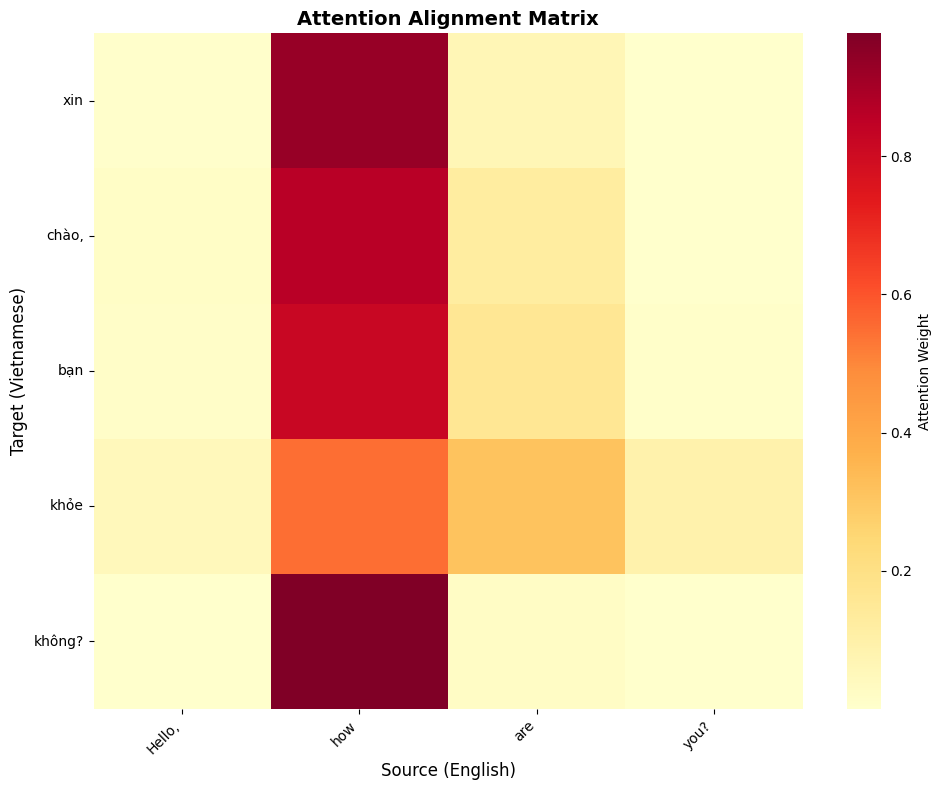

In [ ]:
def visualize_attention(src_sentence, translation, attention, src_vocab, tgt_vocab):
    """Visualize attention weights as heatmap"""
    
    # Decode sentences
    src_words = src_sentence.split()
    tgt_words = translation.split()
    
    # Trim attention to actual lengths
    attention = attention[:len(tgt_words), :len(src_words)]
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    sns.heatmap(
        attention,
        xticklabels=src_words,
        yticklabels=tgt_words,
        cmap='YlOrRd',
        ax=ax,
        cbar_kws={'label': 'Attention Weight'}
    )
    
    ax.set_xlabel('Source (English)', fontsize=12)
    ax.set_ylabel('Target (Vietnamese)', fontsize=12)
    ax.set_title('Attention Alignment Matrix', fontsize=14, fontweight='bold')
    
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Visualize attention for a sample
sample_idx = 0
src_text, tgt_text = test_pairs[sample_idx]

src_tensor = torch.tensor([en_vocab.encode(src_text)], dtype=torch.long).to(device)
src_lengths = torch.tensor([len(en_vocab.encode(src_text))], dtype=torch.long).to(device)

model.eval()
with torch.no_grad():
    translation, attention = model.translate(src_tensor, src_lengths)

translation_text = vi_vocab.decode(translation[0].cpu().numpy())
attention_weights = attention[0].cpu().numpy()

print(f"Source: {src_text}")
print(f"Target: {tgt_text}")
print(f"Translation: {translation_text}\n")

visualize_attention(src_text, translation_text, attention_weights, en_vocab, vi_vocab)


## 12. Interactive Translation


In [ ]:
def translate_interactive(sentence):
    """Translate a custom sentence"""
    model.eval()
    
    src_tensor = torch.tensor([en_vocab.encode(sentence)], dtype=torch.long).to(device)
    src_lengths = torch.tensor([len(en_vocab.encode(sentence))], dtype=torch.long).to(device)
    
    with torch.no_grad():
        translation, attention = model.translate(src_tensor, src_lengths)
    
    translation_text = vi_vocab.decode(translation[0].cpu().numpy())
    return translation_text

# Try your own sentences
test_sentences = [
    "Hello, how are you?",
    "I love learning languages.",
    "What is your name?",
]

print("INTERACTIVE TRANSLATION")

for sentence in test_sentences:
    translation = translate_interactive(sentence)
    print(f"EN: {sentence}")
    print(f"VI: {translation}\n")


INTERACTIVE TRANSLATION
EN: Hello, how are you?
VI: xin chào, bạn khỏe không?

EN: I love learning languages.
VI: tôi thích học ngôn ngữ.

EN: What is your name?
VI: tên bạn là gì?

